# MODELISATION PART

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2
import os
import time
from pathlib import Path

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, UpSampling2D, Concatenate, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TensorBoard

from sklearn.model_selection import train_test_split

In [104]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Chargement des données

In [107]:
# Chargement des métadonnées
metadata = pd.read_csv(r'../data/processed/metadata.csv')
metadata.head()

FILE NAME FORMAT     SIZE                            IMAGE_URL  \
0  Normal-1    PNG  256*256  ./data/processed/images/image-0.png   
1  Normal-2    PNG  256*256  ./data/processed/images/image-1.png   
2  Normal-3    PNG  256*256  ./data/processed/images/image-2.png   
3  Normal-4    PNG  256*256  ./data/processed/images/image-3.png   
4  Normal-5    PNG  256*256  ./data/processed/images/image-4.png   

                            MASK_URL  
0  ./data/processed/masks/mask-0.png  
1  ./data/processed/masks/mask-1.png  
2  ./data/processed/masks/mask-2.png  
3  ./data/processed/masks/mask-3.png  
4  ./data/processed/masks/mask-4.png

In [108]:
# -------------------------------- A NE PAS COPIER DANS LE SCRIPT FINAL --------------------------------
# Ajout d'un . dans l'URL de l'image et du masque car le notebook est exécuté dans un sous-dossier

metadata["IMAGE_URL"] = metadata["IMAGE_URL"].apply(lambda x: "." + x)
metadata["MASK_URL"] = metadata["MASK_URL"].apply(lambda x: "." + x)

In [109]:
image_paths = metadata["IMAGE_URL"].values
mask_paths = metadata["MASK_URL"].values

In [113]:
# Séparation des données en ensembles d'entraînement, de validation et de test
X_train, X_test_valid, y_train, y_test_valid = train_test_split(image_paths, mask_paths, test_size=0.3, random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(X_test_valid, y_test_valid, test_size=0.5, random_state=42)

In [111]:
def load_images(image_path, mask_path):
    """
    Load images and masks from the given paths.
    """
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=1)
    image = tf.cast(image, tf.float32) / 255.0
    image.set_shape((256, 256, 1))

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.cast(mask, tf.float32) / 255.0
    mask.set_shape((256, 256, 1))

    return image, mask

In [114]:
# Transformation des chemins d'images et de masques en dataset Tensorflow, puis application de la fonction de chargement
# de données sur chaque élément du dataset

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.map(lambda x, y: load_images(x, y),
                      num_parallel_calls=tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
val_ds = val_ds.map(lambda x, y: load_images(x, y),
                      num_parallel_calls=tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = test_ds.map(lambda x, y: load_images(x, y),
                      num_parallel_calls=tf.data.AUTOTUNE)

In [115]:
# Mélange des données dans les datasets,

BATCH_SIZE = 16

train_ds = (
    train_ds
    .shuffle(buffer_size=100)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

val_ds = (
    val_ds
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

test_ds = (
    test_ds
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

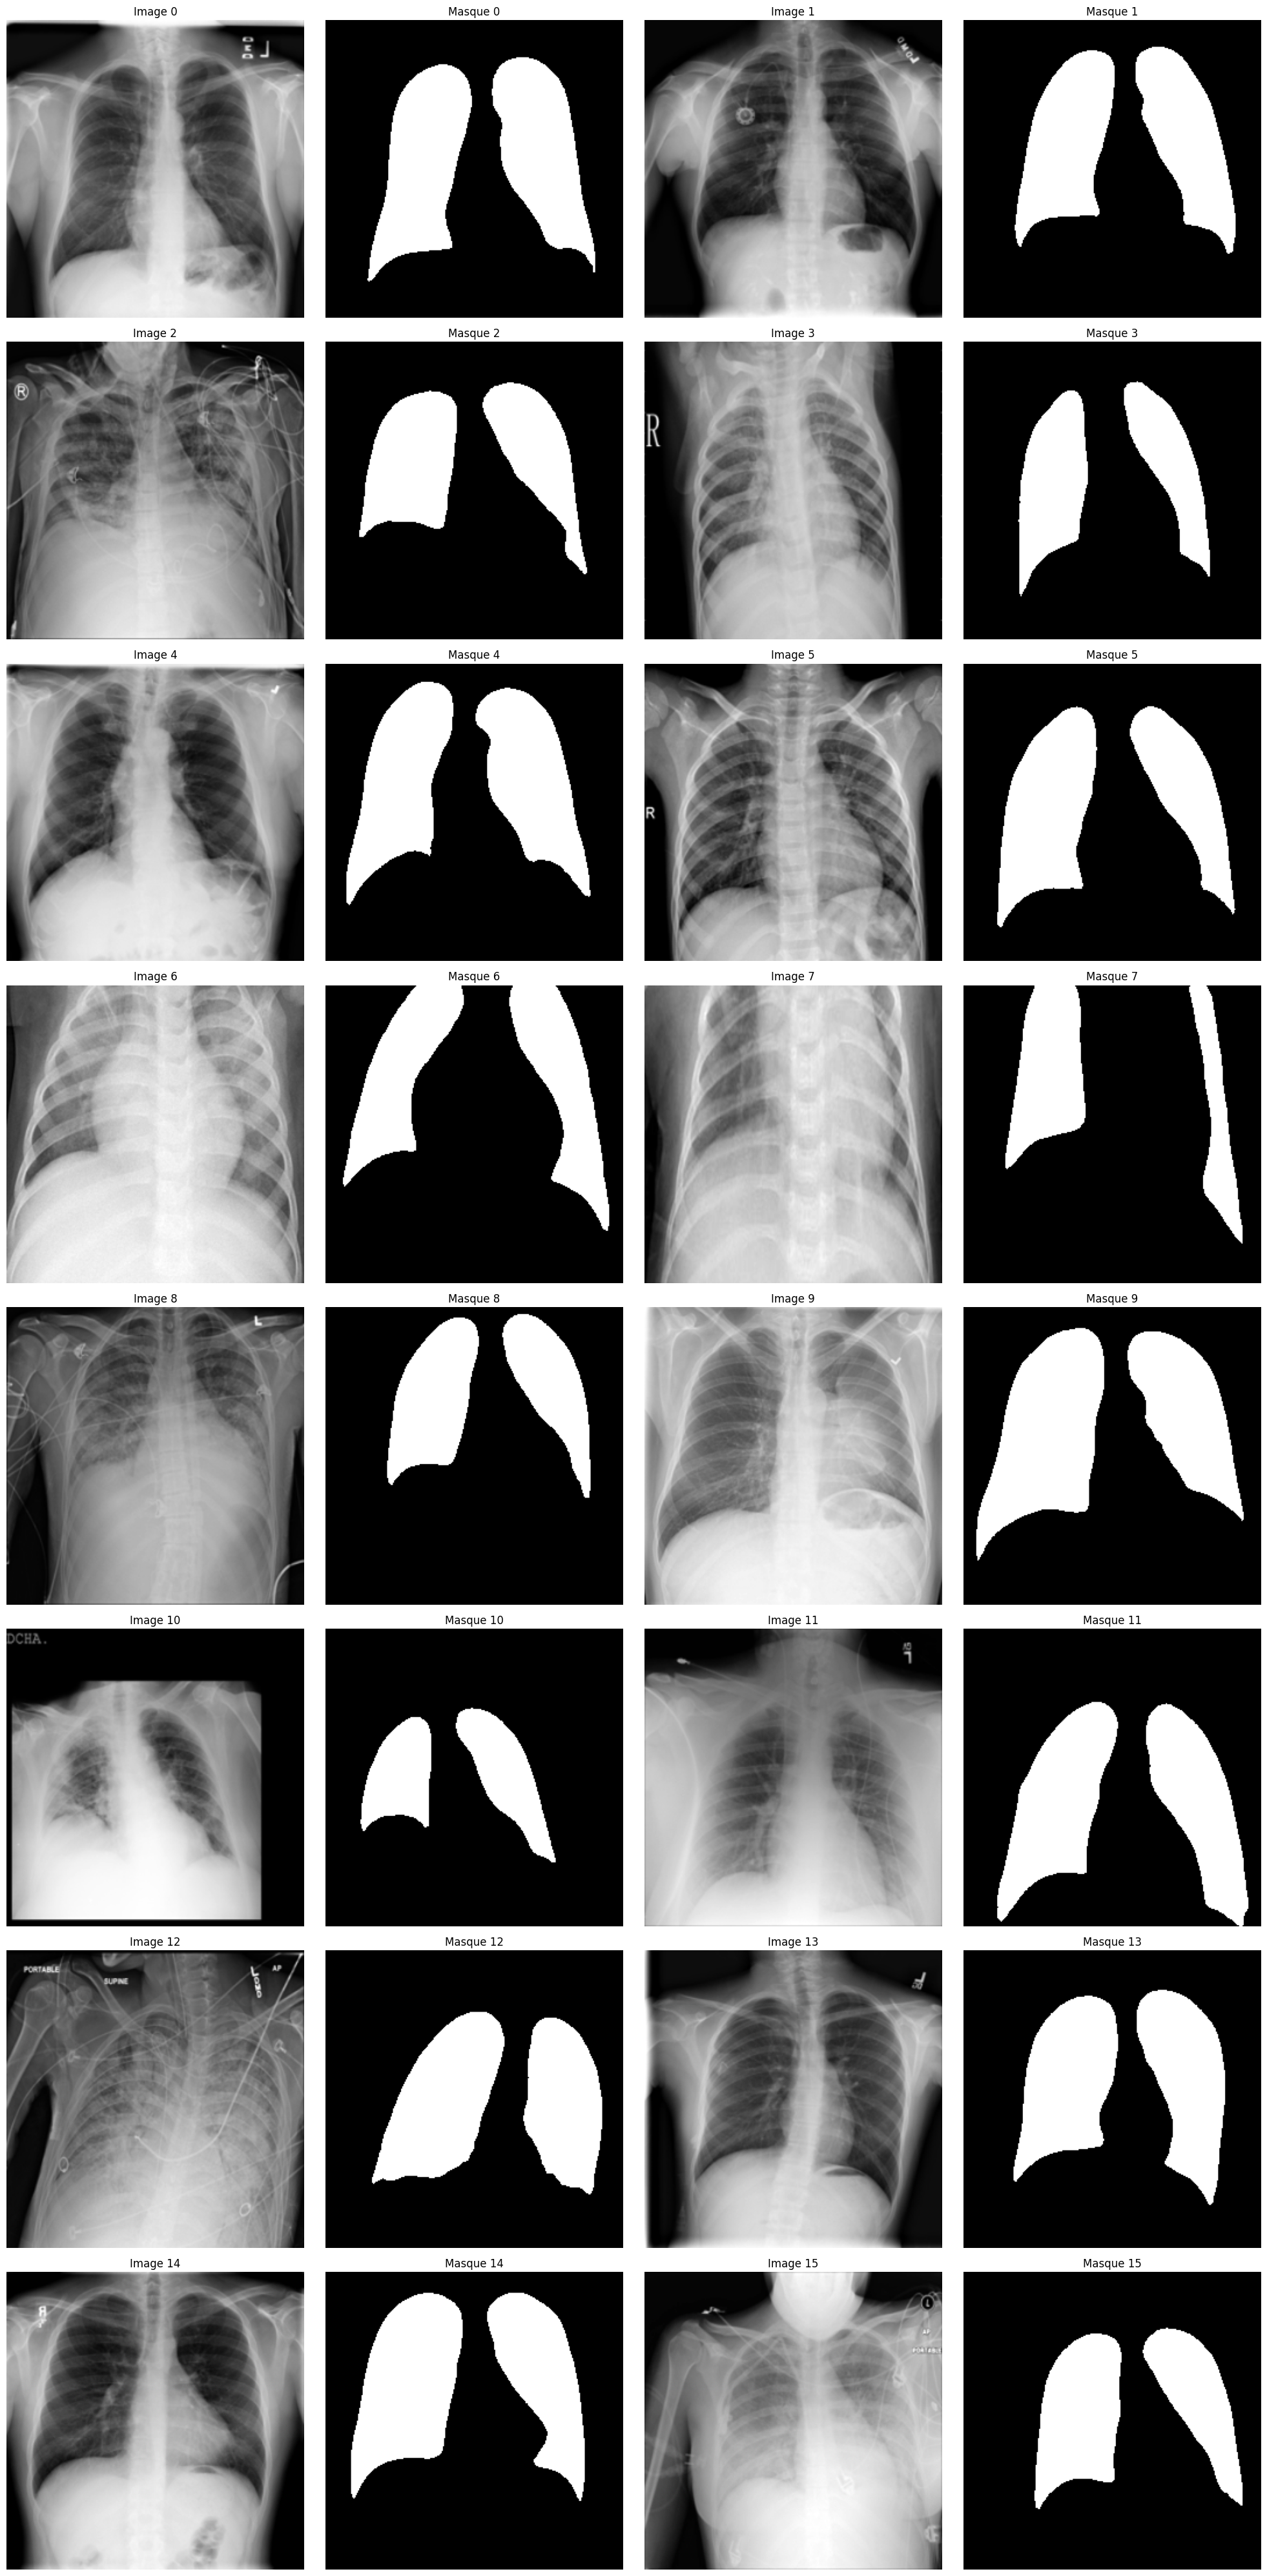

In [116]:
# Extraire un batch
images, masks = next(iter(train_ds))

# Afficher toutes les images du batch
batch_size = images.shape[0]

plt.figure(figsize=(20, batch_size * 2.5))
j = 0
for i in range(1, 2*batch_size, 2):
    plt.subplot(batch_size // 2, 4, i)
    plt.imshow(images[j].numpy(), cmap='gray')
    plt.axis('off')
    plt.title(f'Image {j}')

    plt.subplot(batch_size// 2, 4, i + 1)
    plt.imshow(masks[j].numpy(), cmap='gray')
    plt.axis('off')
    plt.title(f'Masque {j}')
    j += 1

plt.tight_layout()
plt.show()

In [117]:
# Les masques sont bien des images binaires, on peut vérifier les valeurs uniques
np.unique(masks[0].numpy())

array([0., 1.], dtype=float32)

# Modélisation

In [118]:
def down_block(x, filters):
    """
    Downsampling block for the U-Net model.
    """
    x = Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    p = MaxPooling2D((2, 2))(x)
    return x, p

def up_block(x, skip, filters):
    """
    Upsampling block for the U-Net model.
    """
    x = UpSampling2D((2, 2))(x)
    x = Concatenate()([x, skip])
    x = Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    return x

def build_unet(input_shape, first_layer_filters):
    """
    Build the U-Net model.
    """
    inputs = Input(shape=input_shape)

    # Downsampling path
    temp1, x = down_block(inputs, first_layer_filters)
    temp2, x = down_block(x, first_layer_filters * 2)
    temp3, x = down_block(x, first_layer_filters * 4)
    temp4, x = down_block(x, first_layer_filters * 8)

    # Bottleneck
    bottleneck = Conv2D(first_layer_filters * 16, (3, 3), activation='relu', padding='same')(x)
    bottleneck = BatchNormalization()(bottleneck)
    bottleneck = Conv2D(first_layer_filters * 16, (3, 3), activation='relu', padding='same')(bottleneck)
    bottleneck = BatchNormalization()(bottleneck)

    # Upsampling path
    x = up_block(bottleneck, temp4, first_layer_filters * 8)
    x = up_block(x, temp3, first_layer_filters * 4)
    x = up_block(x, temp2, first_layer_filters * 2)
    x = up_block(x, temp1, first_layer_filters)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(x)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.summary()

    return model

In [132]:
def iou_metric(y_true, y_pred, threshold=0.5):
    y_pred = tf.cast(y_pred > threshold, tf.float32)
    y_true = tf.cast(y_true, tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = intersection / (union + tf.keras.backend.epsilon())
    return iou


In [120]:
# Définition des callbacks

model_path = r"../models/unet_filters_c1_16.h5"

modelcheckpoint = ModelCheckpoint(filepath=model_path,
                                  monitor='val_mean_io_u',
                                  verbose=1,
                                  save_best_only=True,
                                  mode="max")

earlystop = EarlyStopping(monitor="val_loss",
                          mode="min",
                          min_delta=0,
                          patience=8,
                          verbose=1,
                          restore_best_weights=True)

reducelr = ReduceLROnPlateau(monitor="val_loss",
                             min_lr=0.00001,
                             patience=4,
                             factor=0.5,
                             cooldown=2,
                             verbose=1)

In [135]:
root_logdir = os.path.join(os.curdir, 'reports/my_logs')
tensorboard = TensorBoard(os.path.join(root_logdir, time.strftime("%Y%m%d-%H:%M") + "-run_unet_1st_layer_16_filters"))

In [123]:
# Construction du modèle U-Net
input_shape = (256, 256, 1)
unet = build_unet(input_shape, 16)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 256, 256,  │        160 │ input_layer_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 256, 256,  │      2,320 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 128, 128,  │      4,640 │ max_pooling2d_4[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 128, 128,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_5[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_23[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 64, 64,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_24[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_6[

 Total params: 1,968,225 (7.51 MB)

 Trainable params: 1,965,281 (7.50 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [136]:
# Compilation du modèle
unet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', iou_metric])

In [137]:
with tf.device('/GPU:0'):
    # Entraînement du modèle
    history = unet.fit(train_ds,
                        validation_data=val_ds,
                        epochs=50,
                        callbacks=[modelcheckpoint, earlystop, reducelr, tensorboard],
                        verbose=1)

Epoch 1/50


926/926 ━━━━━━━━━━━━━━━━━━━━ 201s 208ms/step - accuracy: 0.9831 - iou_metric: 0.9311 - loss: 0.0472 - val_accuracy: 0.9871 - val_iou_metric: 0.9483 - val_loss: 0.0323 - learning_rate: 0.0010
Epoch 2/50


/home/antoine/MachineLearning/projects/COVID19/Radiography_project_LungIsolation/.venv/lib/python3.9/site-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_mean_io_u available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


926/926 ━━━━━━━━━━━━━━━━━━━━ 148s 159ms/step - accuracy: 0.9902 - iou_metric: 0.9596 - loss: 0.0245 - val_accuracy: 0.9911 - val_iou_metric: 0.9635 - val_loss: 0.0231 - learning_rate: 0.0010
Epoch 3/50
926/926 ━━━━━━━━━━━━━━━━━━━━ 152s 164ms/step - accuracy: 0.9920 - iou_metric: 0.9671 - loss: 0.0195 - val_accuracy: 0.9914 - val_iou_metric: 0.9645 - val_loss: 0.0228 - learning_rate: 0.0010
Epoch 4/50
926/926 ━━━━━━━━━━━━━━━━━━━━ 152s 164ms/step - accuracy: 0.9926 - iou_metric: 0.9695 - loss: 0.0179 - val_accuracy: 0.9912 - val_iou_metric: 0.9641 - val_loss: 0.0225 - learning_rate: 0.0010
Epoch 5/50
926/926 ━━━━━━━━━━━━━━━━━━━━ 147s 159ms/step - accuracy: 0.9935 - iou_metric: 0.9731 - loss: 0.0155 - val_accuracy: 0.9928 - val_iou_metric: 0.9706 - val_loss: 0.0182 - learning_rate: 0.0010
Epoch 6/50
926/926 ━━━━━━━━━━━━━━━━━━━━ 150s 162ms/step - accuracy: 0.9940 - iou_metric: 0.9750 - loss: 0.0146 - val_accuracy: 0.9913 - val_iou_metric: 0.9644 - val_loss: 0.0219 - learning_rate: 0.0010
E

In [138]:
unet.save(model_path)
# Sauvegarde du modèle

In [84]:
model = tf.keras.models.load_model(model_path, custom_objects={'MeanIoU': tf.keras.metrics.MeanIoU(num_classes=2)})

In [85]:
model.evaluate(test_ds)

199/199 ━━━━━━━━━━━━━━━━━━━━ 23s 107ms/step - accuracy: 0.9952 - loss: 0.0132 - mean_io_u: 0.7522


[0.013113628141582012, 0.9951977133750916, 0.7533961534500122]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)


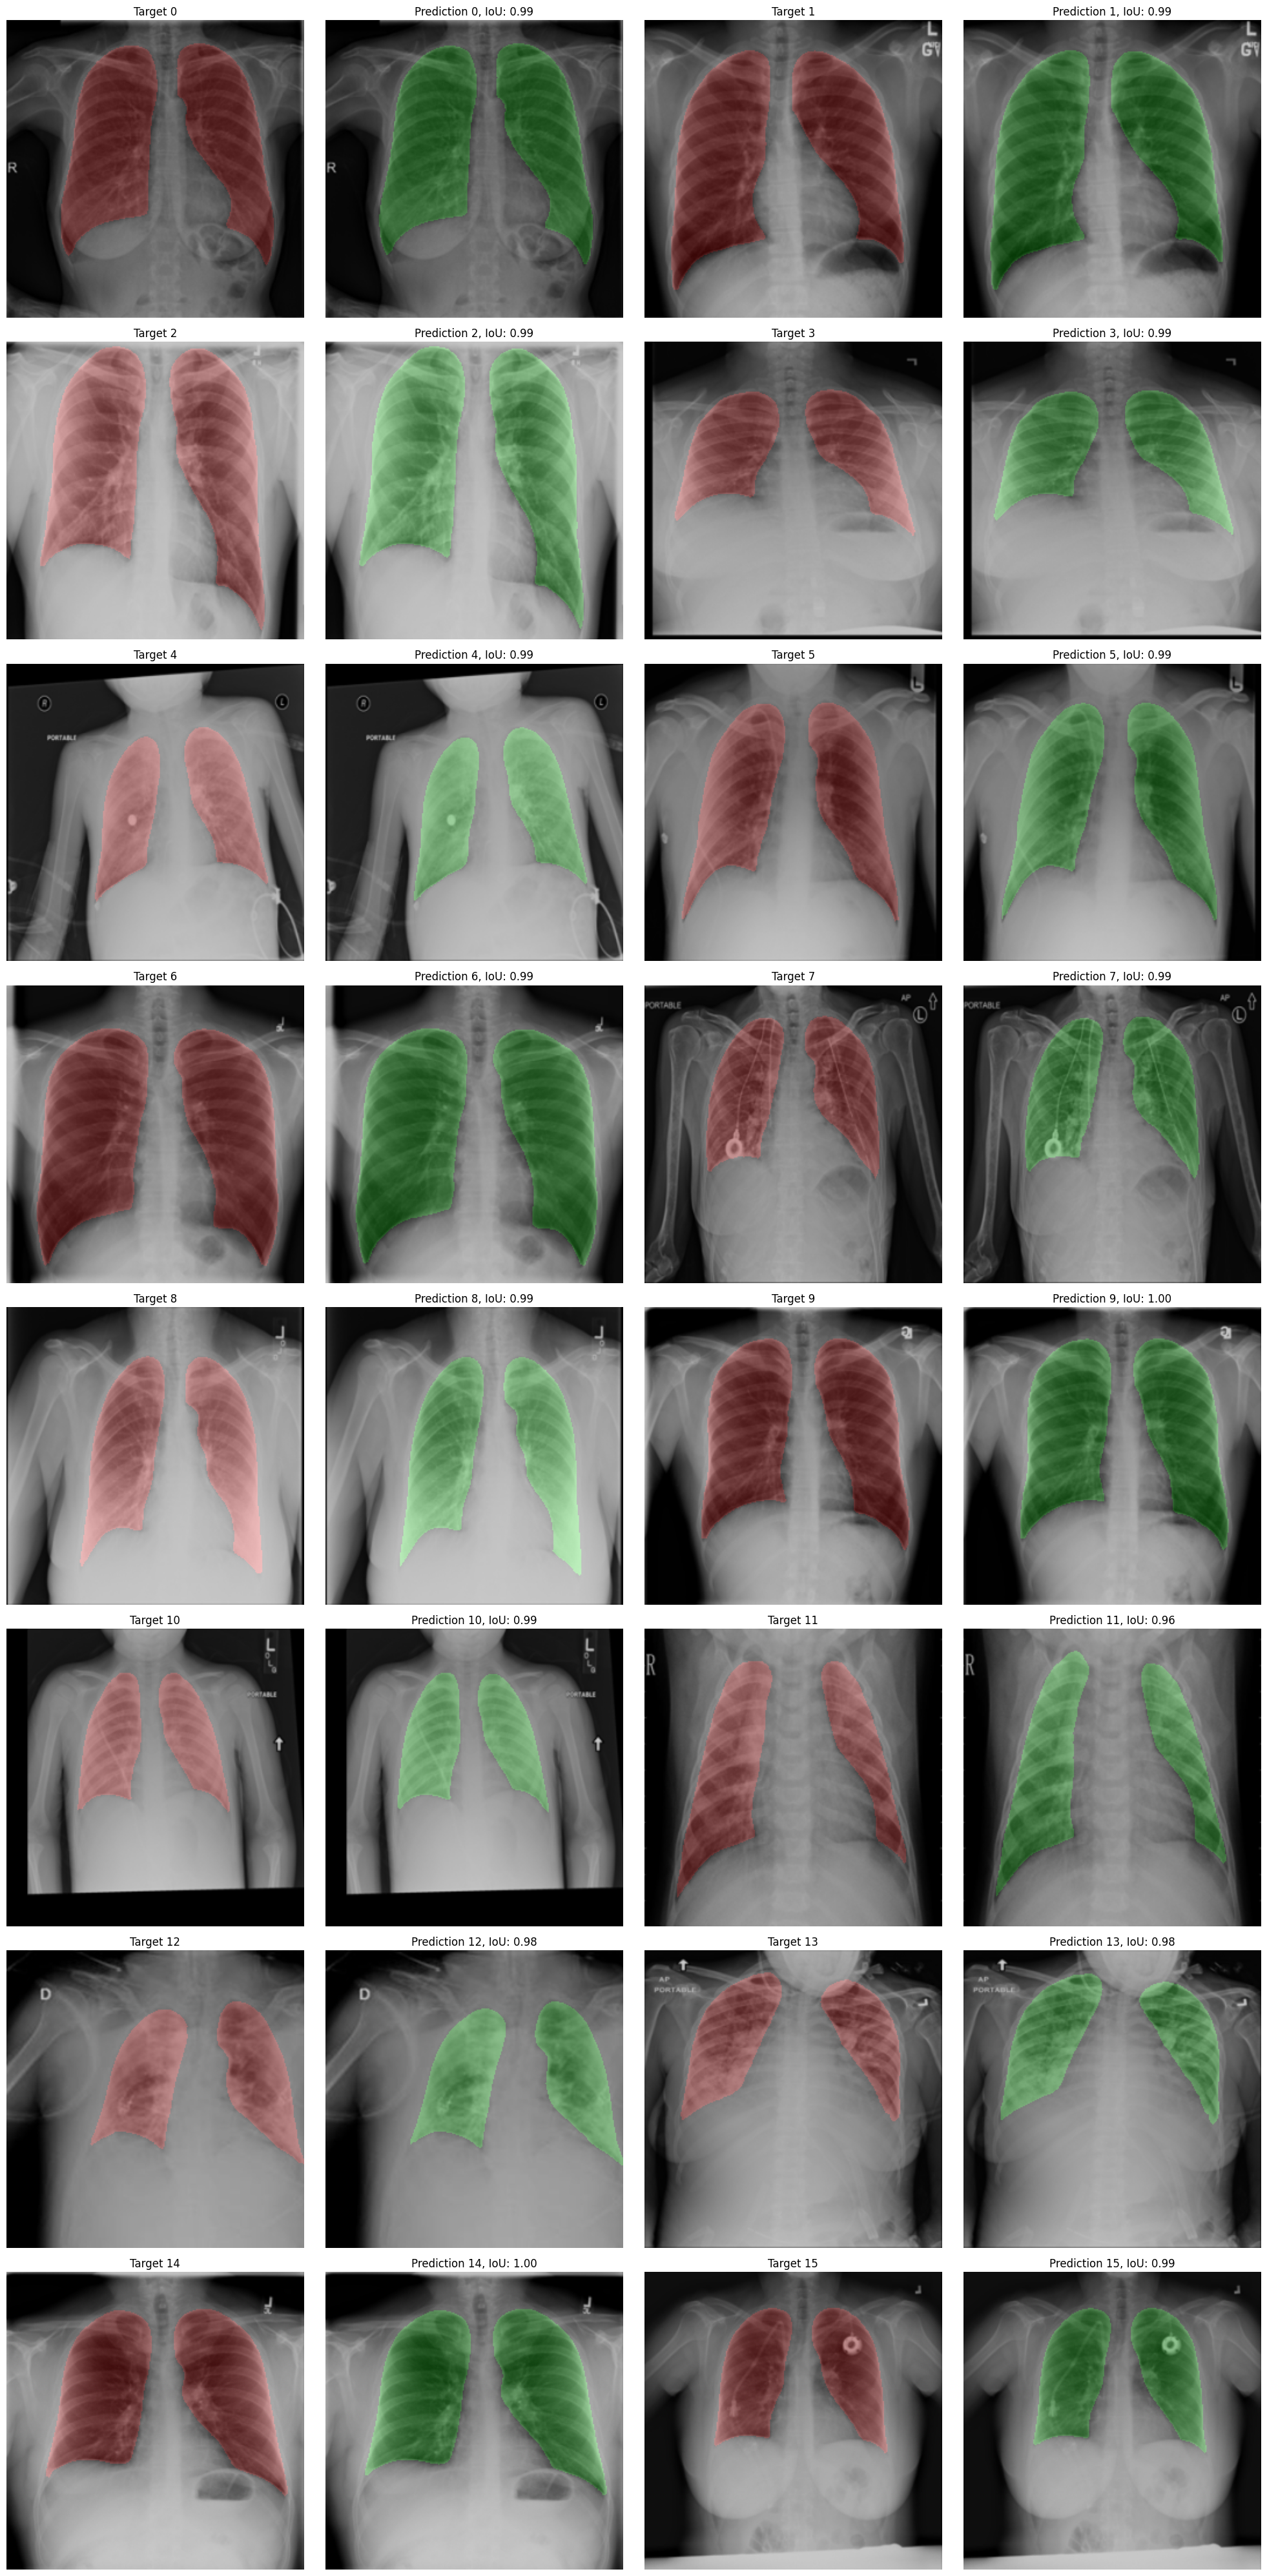

Global Mean IoU: 0.99


In [102]:
# Extraire un batch
images, masks = next(iter(test_ds))
predictions = model.predict(images)
predictions = np.where(predictions > 0.5, 1, 0)


target = masks
zeros = np.zeros(target.shape)
target = np.concatenate((target, zeros, zeros), axis=3)
predictions_rgb = np.concatenate((zeros, predictions, zeros), axis=3)

global_mean_iou = tf.keras.metrics.MeanIoU(num_classes=2)

# Afficher toutes les images du batch
batch_size = images.shape[0]
alpha = 0.2
plt.figure(figsize=(20, batch_size * 2.5))
j = 0
for i in range(1, 2*batch_size, 2):
    
    image = cv2.cvtColor(images[j].numpy(), cv2.COLOR_GRAY2RGB).astype(np.float32)
    target_mask = target[j].astype(np.float32)
    masked_target = cv2.addWeighted(image, 1 - alpha, target_mask, alpha, 0)

    prediction_mask = predictions_rgb[j].astype(np.float32)
    masked_prediction = cv2.addWeighted(image, 1 - alpha, prediction_mask, alpha, 0)

    local_mean_iou = tf.keras.metrics.MeanIoU(num_classes=2)
    global_mean_iou.update_state(masks[j], predictions[j])
    local_mean_iou.update_state(masks[j], predictions[j])
    
    plt.subplot(batch_size // 2, 4, i)
    plt.imshow(masked_target)
    plt.axis('off')
    plt.title(f'Target {j}')

    plt.subplot(batch_size// 2, 4, i + 1)
    plt.imshow(masked_prediction)
    plt.axis('off')
    plt.title(f'Prediction {j}, IoU: {local_mean_iou.result().numpy():.2f}')
    j += 1

    local_mean_iou.reset_state()

plt.tight_layout()
plt.show()

print(f"Global Mean IoU: {global_mean_iou.result().numpy():.2f}")

In [139]:
# Construction du modèle U-Net
input_shape = (256, 256, 1)
unet = build_unet(input_shape, 32)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 256, 256,  │        320 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_38[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 256, 256,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_39[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 128, 128,  │     18,496 │ max_pooling2d_8[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_40[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 128, 128,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_41[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_9[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_42[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 64, 64,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_43[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_10

 Total params: 7,857,857 (29.98 MB)

 Trainable params: 7,851,969 (29.95 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [140]:
# Compilation du modèle
unet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', iou_metric])

In [141]:
root_logdir = os.path.join(os.curdir, 'reports/my_logs')
tensorboard = TensorBoard(os.path.join(root_logdir, time.strftime("%Y%m%d-%H:%M") + "-run_unet_1st_layer_32_filters"))

In [142]:
model_path = r"../models/unet_filters_c1_32.h5"

In [143]:
with tf.device('/GPU:0'):
    # Entraînement du modèle
    history_2 = unet.fit(train_ds,
                        validation_data=val_ds,
                        epochs=50,
                        callbacks=[modelcheckpoint, earlystop, reducelr, tensorboard],
                        verbose=1)

Epoch 1/50


/home/antoine/MachineLearning/projects/COVID19/Radiography_project_LungIsolation/.venv/lib/python3.9/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_304']
Received: inputs=Tensor(shape=(None, 256, 256, 1))
  warnings.warn(msg)


926/926 ━━━━━━━━━━━━━━━━━━━━ 337s 350ms/step - accuracy: 0.9649 - iou_metric: 0.8834 - loss: 0.1025 - val_accuracy: 0.9824 - val_iou_metric: 0.9281 - val_loss: 0.0573 - learning_rate: 0.0010
Epoch 2/50


/home/antoine/MachineLearning/projects/COVID19/Radiography_project_LungIsolation/.venv/lib/python3.9/site-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_mean_io_u available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


926/926 ━━━━━━━━━━━━━━━━━━━━ 323s 349ms/step - accuracy: 0.9886 - iou_metric: 0.9534 - loss: 0.0293 - val_accuracy: 0.9877 - val_iou_metric: 0.9507 - val_loss: 0.0333 - learning_rate: 0.0010
Epoch 3/50
926/926 ━━━━━━━━━━━━━━━━━━━━ 325s 350ms/step - accuracy: 0.9917 - iou_metric: 0.9658 - loss: 0.0204 - val_accuracy: 0.9890 - val_iou_metric: 0.9547 - val_loss: 0.0317 - learning_rate: 0.0010
Epoch 4/50
926/926 ━━━━━━━━━━━━━━━━━━━━ 330s 356ms/step - accuracy: 0.9925 - iou_metric: 0.9688 - loss: 0.0184 - val_accuracy: 0.9896 - val_iou_metric: 0.9571 - val_loss: 0.0293 - learning_rate: 0.0010
Epoch 5/50
926/926 ━━━━━━━━━━━━━━━━━━━━ 326s 351ms/step - accuracy: 0.9932 - iou_metric: 0.9720 - loss: 0.0163 - val_accuracy: 0.9837 - val_iou_metric: 0.9326 - val_loss: 0.0453 - learning_rate: 0.0010
Epoch 6/50
926/926 ━━━━━━━━━━━━━━━━━━━━ 326s 352ms/step - accuracy: 0.9934 - iou_metric: 0.9728 - loss: 0.0157 - val_accuracy: 0.9895 - val_iou_metric: 0.9567 - val_loss: 0.0269 - learning_rate: 0.0010
E